Figure 1D inset, chemostat going from initial coniditons to steady state  
Code here is mostly the same as in cnv_simulation.py

Equations for chemostat competition:  
$$
\frac{dX_A}{dt} = X_A ( \frac{\mu S}{S + k_A} - D ), \\
\frac{dX_C}{dt} = X_C ( \frac{r_C S}{S + k_C}  - D ), \\
\frac{dX_N}{dt} = X_N ( \frac{r_N S}{S + k_N} - D ), \\
\frac{dS}{dt} = ( S_0 - S ) D - \frac{X_A \mu S}{( S + k_A ) Y_A} - \frac{X_C r_C S}{( S + k_C ) Y_C} - \frac{X_N r_N S}{( S + k_N ) Y_N}.
$$

Where:
* $X_A$ is the density of the wildtype strain
* $X_C$ is the density of the CNV strain
* $X_N$ is the density of the SNV strain
* $S$ is the concentration of the limiting nutrient in the medium
* $S_0$ is the incoming substrate flow
* $Y_i$ is the culture yield of strain $i$ per mole of the limiting nutrient
* $D$ is the dilution rate of the culture
* $\mu$ is the maximal growth rate, related to the concentration of the limiting nutrient with saturating kinetics,
* $k_i$ is the substrate concentration at half-maximal $\mu$ for strain $i$ 
* $r_C=(\frac{s_C}{T} + \mu)$  is the increased growth in the chemostat conditions of the CNV strain
* $r_N=(\frac{s_N}{T} + \mu))$  is the increased growth in the chemostat conditions of the CNV strain
* $T$ is the generation time in hours


Equations for mutation from ancestral genotype to mutant genotype:

$$
\frac{dX_A}{dt} = (1 - \delta_C - \delta_S) X_A,\\
\frac{dX_C}{dt} = \delta_C X_A, \\
\frac{dX_N}{dt} = \delta_N X_A.
$$



Based on Airoldi et al. 2016 https://doi.org/10.1091/mbc.E14-05-1013, the values for the parameters are:

* $k_i$ = 103µM nitrogen = 0.103 mM
* $Y$ = 32,445 ± 3422 cells/ml per μmol of nitrogen = 32,445,000 cells/ml/mmol nitrogen
* at steady state, $S$ = ∼80 μM = ~0.08 mM

Based on Cooper TG (1982):
* $\mu_A$ = 0.45 h-1

From experiments:
* $D$ = 0.12 h-1
* $S_0$ = 800 μM = 0.8 mM
* at steady state, cell density ~1.5e7 cells/ml, total population size ~3e8
* total volume = 20 ml

This results in a doubling time of T=5.8 hours, which is equal to 0.1724 generations h-1

In [1]:
import numpy as np
import numba

def get_params(parameters):
    if isinstance(parameters, np.ndarray):
        s_cnv, m_cnv = np.power(10,parameters)
    if not isinstance(parameters, np.ndarray):
        s_cnv = np.power(10,parameters.s)
        m_cnv = np.power(10,parameters.m)
    return s_cnv,m_cnv

@numba.jit
def get_rates(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv):
    """ Rates
    A :  number of ancestral cells at current time step
    CNV : number of cells with CNV at current time step
    SNV : number of cells with SNV at current time step
    S : substrate concentration at current time step
    k : substrate concentration at half-maximal growth rate (here, the same for all cells)
    D : dilution rate
    μA : ancestral maximum growth rate
    m_cnv : ancestral -> CNV mutation rate
    m_snv : ancestral -> SNV mutation rate
    s_cnv : CNV selection coefficient
    s_snv : SNV selection coefficient
    """
    return np.array([
        A* ((μA *S) / (k + S)), # growth ancestral
        A*D, # dilution ancestral
        CNV * (((μA+s_cnv) *S) / (k + S)), # growth CNV 
        CNV*D, # dilution CNV
        SNV * (((μA+s_snv) *S) / (k + S)), # growth SNV
        SNV*D, # dilution SNV
        A * m_cnv, # ancestral -> CNV
        A * m_snv],#, # ancestral -> SNV
        dtype='float64'
    )

updates = np.array([
        [1, 0, 0], # growth ancestral
        [-1, 0, 0], # dilution ancestral
        [0, 1, 0],  # growth CNV
        [0, -1, 0], # dilution CNV
        [0, 0, 1],  # growth SNV
        [0, 0, -1], # dilution SNV
        [-1, 1, 0], # mutation ancestral -> CNV
        [-1, 0, 1] # mutation ancestral -> SNV
    ])

def τ_leap(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv, S0, y, τ):
    """ Single update of simulation using tau leaps
    A :  number of ancestral cells at current time step
    CNV : number of cells with CNV at current time step
    SNV : number of cells with SNV at current time step
    S : substrate concentration at current time step
    k : substrate concentration at half-maximal growth rate (here, the same for all cell types)
    D : dilution rate
    μA : ancestral maximum growth rate
    m_cnv : ancestral -> CNV mutation rate
    m_snv : ancestral -> SNV mutation rate
    s_cnv : CNV selection coefficient
    s_snv : SNV selection coefficient
    updates : change in reactants due to reactions
    S0 : incoming substrate concentration - S0 in diff eq
    y : number of cells produced per mole of the limiting nutrient (here, the same for all cell types)
    τ : amount to advance time
    """
    rates = get_rates(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv)
    try:
        adj_rates = np.random.poisson(rates * τ)
    except ValueError:
        print(rates, τ)
        raise
    if (adj_rates > 150).any() and τ > 1/100:
        τ /= 2
    ΔA, ΔCNV, ΔSNV = updates.T @ adj_rates
    A += ΔA
    CNV += ΔCNV
    SNV += ΔSNV
    ΔS = S0*D - D*S - (A*μA*S)/((S+k)*y) - (CNV*(μA+s_cnv)*S)/((S+k)*y) - (SNV*(μA+s_snv)*S)/((S+k)*y)
    return τ, A, CNV, SNV, S+ΔS



In [2]:
# I will run this with no mutants, so m_snv=0 and m_cnv=0
m_snv=0
s_snv=0
cnv_params = np.array([0, 0])
reps=1
# chemostat parameters
A_inoculation = 1.5e7
S_init = .800
D=0.12
μA=0.35
k=.103
y=32445000*20
S0=.800
τ=1/10

In [3]:
assert A_inoculation > 0
A_inoculation = np.uint64(A_inoculation)
    
s_cnv, m_cnv = cnv_params


s_cnv = (s_cnv*μA)/np.log(2)
m_cnv /= 5.8 #convert from per generation to per hour
s_snv = (s_snv*μA)/np.log(2)
m_snv /= 5.8




A = A_inoculation
S = S_init # initial substrate concentration = concentration in media
CNV, SNV = 0, 0
t=0
    
# while t < 48: # allow chemostat to reach steady state
#     τ, A, CNV, SNV, S = τ_leap(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv, S0, y, τ)
#     A = max(A, 0)
#     CNV = max(CNV, 0)
#     SNV = max(SNV, 0)
#     S = max(S, 0)
#     t += τ
        
states = [np.array([A, CNV, SNV, S])]
times=[t]
max_t = 100# run for 100 hours
while t < max_t: # record from when the chemostat reaches steady state to hour that corresponds with the last generation
    τ, A, CNV, SNV, S = τ_leap(A, CNV, SNV, S, k, D, μA, m_cnv, m_snv, s_cnv, s_snv, S0, y, τ)
    A = max(A, 0)
    CNV = max(CNV, 0)
    SNV = max(SNV, 0)
    S = max(S, 0)
    t+=τ
    states.append(np.array([A, CNV, SNV, S]))
    times.append(t)

In [4]:
data = np.stack(states, axis=1)
times = np.array(times)
gens = times/5.8

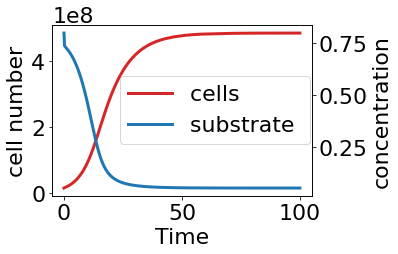

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots()
ax1.plot(times, data[0,:], lw=3, label='cells' + " ", color='tab:red')
ax1.set_xlabel('Time')
ax1.set_ylabel('cell number')

ax2 = ax1.twinx()
ax2.plot(times, data[3,:], lw=3, label='substrate' + " ", color='tab:blue')
ax2.set_ylabel('concentration')
fig.legend(loc=(0.3,0.43))
fig.tight_layout()
plt.savefig('Fig1Dinset.pdf')

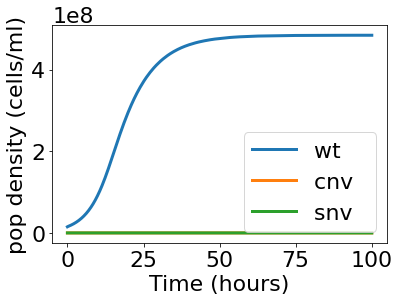

In [14]:
fig, ax = plt.subplots()
ax.plot(times, data[0,:], lw=3, label='wt ' + " ")
ax.plot(times, data[1,:], lw=3, label='cnv ' + " ")
ax.plot(times, data[2,:], lw=3, label='snv ' + " ")
ax.set_xlabel('Time (hours)')
ax.set_ylabel('pop density (cells/ml)')
ax.legend()